## <center>Prediction of customer spending</center>

### Description

Based on the purchase history of five thousand customers who made their first purchase on a website in 2012, predict the total spend of all of the customers in the dataset in 2014.

Transaction history and some information about the customers are provided in two files.

In [1]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Datasets

In [2]:
# Transaction history
trans = pd.read_csv('data/user_transactions.csv', parse_dates=['OrderDate_GMT'])
print('Transactions dataset shape:', trans.shape)
display(trans.head(3))

# Users
users = pd.read_csv('data/user_dat.csv')
print('Users dataset shape:', users.shape)
display(users.head(3))

Transactions dataset shape: (13707, 3)


,UserID,OrderDate_GMT,OrderValue
0,1303089,2012-08-29,302.273
1,1303089,2012-07-04,144.913
2,477723,2012-06-18,227.230


Users dataset shape: (5021, 9)


,UserID,Birthday,IsSubscribed,SubscribeDate,GenderFinal,IsVIP,HasUsedWishlist,IsUsingMultipleDevices,SK_GeoCountry
0,4527721,NaN,Yes,2012-12-12 13:52:28.757,N/D,Not VIP,No,No,216
1,4533703,NaN,Yes,2012-12-12 21:18:53.220,N/D,Not VIP,No,No,216
2,4542738,NaN,No,NaN,N/D,Not VIP,No,No,29


### Distribution of transaction values

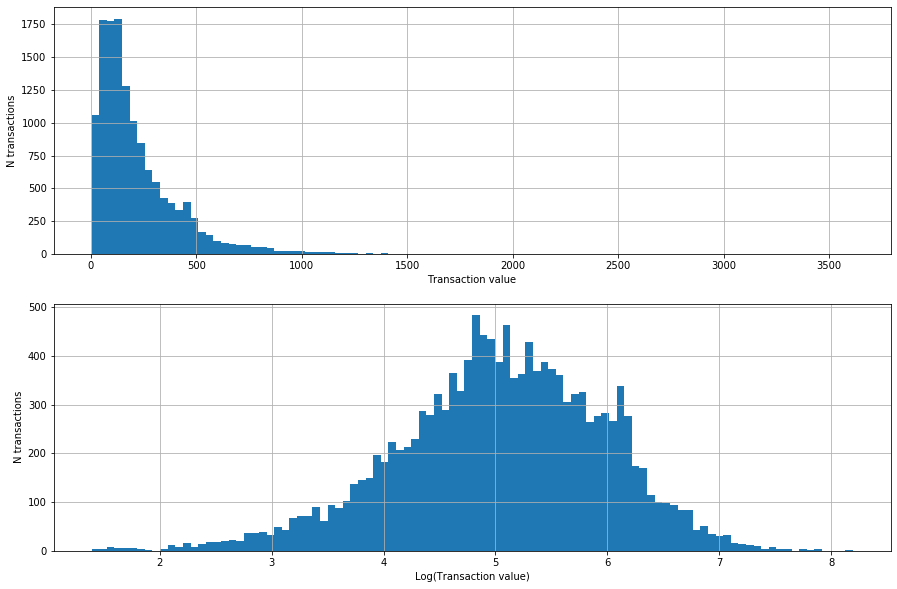

In [3]:
figsize(15, 10)
plt.subplot(211)
_ = plt.hist(trans.OrderValue, bins=100)
plt.xlabel('Transaction value')
plt.ylabel('N transactions')
plt.grid()

plt.subplot(212)
_ = plt.hist(trans.OrderValue.apply(lambda x: np.log(x)), bins=100)
plt.xlabel('Log(Transaction value)')
plt.ylabel('N transactions')
plt.grid()

Normality tests:
Shapiro test (0.9919236302375793, 5.165695400468423e-27)
Kolmogorov-Smirnov test KstestResult(statistic=0.9852767665278284, pvalue=0.0)

Compare Log-normal and Log-logistic distributions:


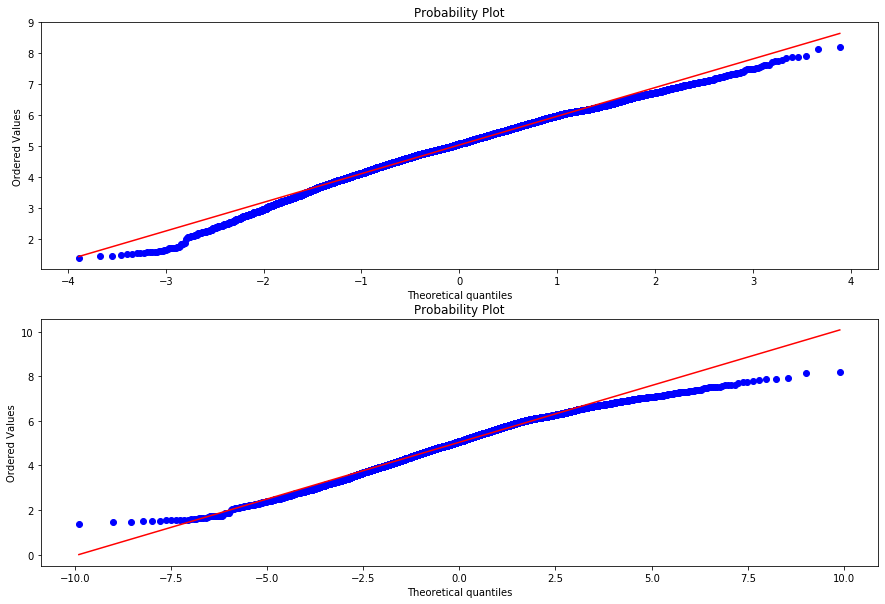

In [4]:
# This looks like a Log-normal distribution, but also similar to Log-logistic one.

# Check normality of Log(transactions) distribution
from scipy import stats

print('Normality tests:')
print('Shapiro test', stats.shapiro(trans.OrderValue.apply(lambda x: np.log(x))))
print('Kolmogorov-Smirnov test', stats.kstest(trans.OrderValue.apply(lambda x: np.log(x)), 'norm', N=100))


print('\nCompare Log-normal and Log-logistic distributions:')
figsize(15, 10)
_ = stats.probplot(trans.OrderValue.apply(lambda x: np.log(x)),
                   dist=stats.norm,
                   plot=plt.subplot(211))

_ = stats.probplot(trans.OrderValue.apply(lambda x: np.log(x)),
                   dist=stats.logistic,
                   plot=plt.subplot(212))

### Fit log-normal distribution to the data

 - Transaction values distribution is closer to Log-normal distribution than to Log-logistic one.
 - Both normality tests rejected the null hypothesis.

In scipy.stats package log-normal pdf is defined in the following form, where $s$ is a shape parameter and 
$y = \left(\frac{x - loc}{scale}\right)$ :

<center>$ f(y, s) = \frac{1}{sy\sqrt{2\pi}}\exp\left({-\frac{\log^2{y}}{2s^2}}\right) $</center>

shape, Log(scale): 0.9295423228874669 5.041507543330002


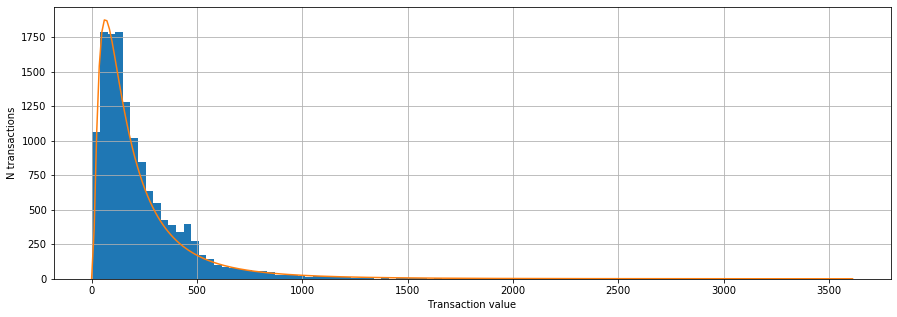

In [5]:
figsize(15, 5)
_ = plt.hist(trans.OrderValue, bins=100)
plt.xlabel('Transaction value')
plt.ylabel('N transactions')
plt.grid()

shape, loc, scale = params = stats.lognorm.fit(trans.OrderValue, floc=0)
print('shape, Log(scale):', shape, np.log(scale))


x = np.linspace(0, trans.OrderValue.max(), 300)
plt.plot(x, 440000*stats.lognorm.pdf(x, shape, loc, scale))

### Investigation of the number of transactions

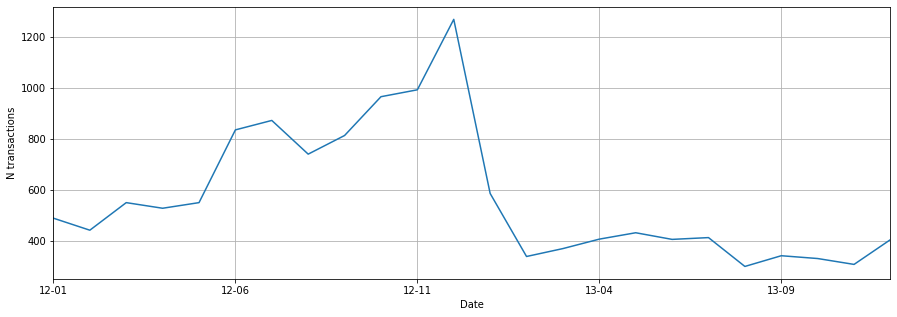

In [6]:
# All transactions

import arrow  # datetime formatting

figsize(15, 5)
trans.OrderDate_GMT.apply(lambda x: arrow.get(x).format('YY-MM')).value_counts().sort_index().plot()
plt.xlabel('Date')
plt.ylabel('N transactions')
plt.grid()

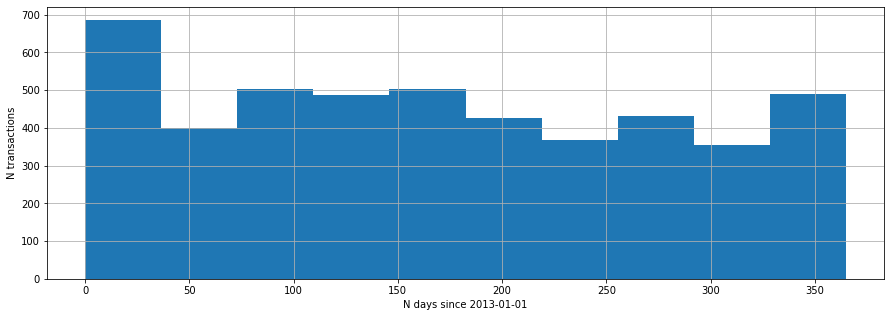

In [7]:
# Transactions in 2013

trans_values = (trans[trans.OrderDate_GMT >= arrow.get('2013-01-01').datetime.replace(tzinfo=None)]
                .assign(val = lambda x: x.OrderDate_GMT.apply(lambda y: (arrow.get(y) - arrow.get('2013-01-01')).total_seconds() / 3600 / 24))
               ).val.values

n, bins, _ = plt.hist(trans_values, bins=np.linspace(0, 365, 11))
plt.xlabel('N days since 2013-01-01')
plt.ylabel('N transactions')
plt.grid()

### Modelling number of transactions

I'm going to model observed numbers of transactions as a non-homogenous Poisson process where the parameter $\mu \sim \exp(-t/\tau)$ 

In [8]:
import pymc3 as pm
import theano

x = 0.5*(bins[:-1] + bins[1:])
t = theano.shared(x)

with pm.Model() as model:
    a = pm.Uniform('a', lower=min(n), upper=max(n))
    tau = pm.Uniform('tau', lower=0, upper=2000)
    
    # setup mu
    mu = pm.Deterministic('mu', a*theano.tensor.exp(-t/tau))
    # poisson process
    observation = pm.Poisson('obs', mu=mu, observed=n)
    
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [a]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:07<00:00, 7969.22draws/s] 
The number of effective samples is smaller than 10% for some parameters.


<Figure size 504x504 with 0 Axes>

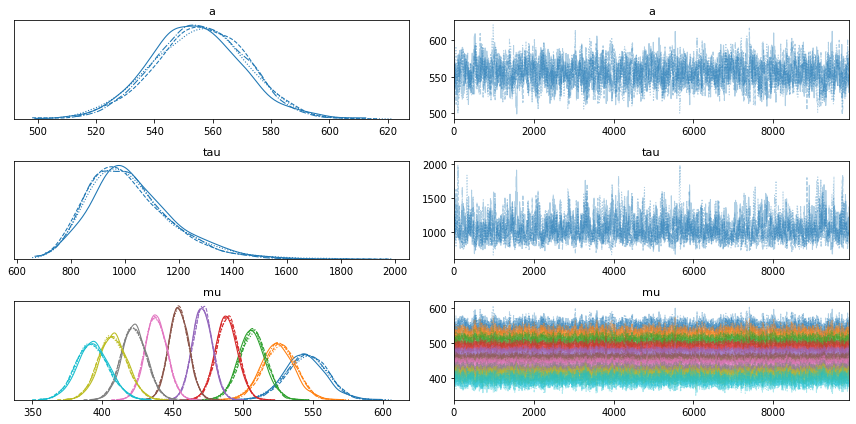

In [9]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace[100:])
plt.tight_layout();

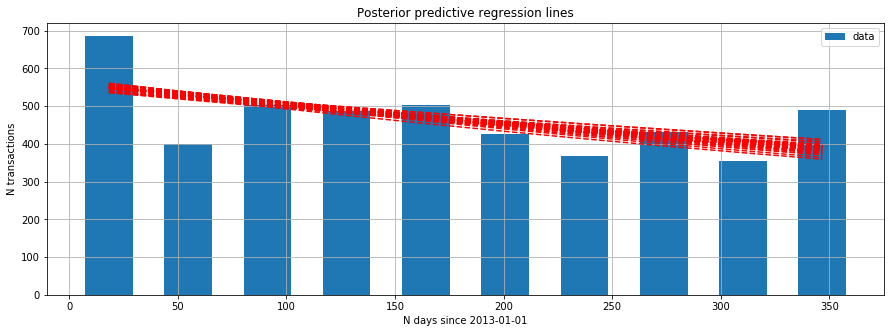

In [10]:
# Plot posterior predictive regression lines

figsize(15, 5)
# Observed data
plt.bar(x, n, width=1.2*x[0], label='data')
# Show first 50 lines for mu parameter
plt.plot(x, trace['mu'][:50].T, 'r--')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('N days since 2013-01-01')
plt.ylabel('N transactions')
plt.ylim([0, 1.05*max(n)])
plt.grid()

### Predict number of transactions in 2014

Time points in 2014 (days from 1st Jan 2013):
[383.25 419.75 456.25 492.75 529.25 565.75 602.25 638.75 675.25 711.75]

mu_2014 initial shape: (40000, 10)

m_2014 new shape: (10000, 10)


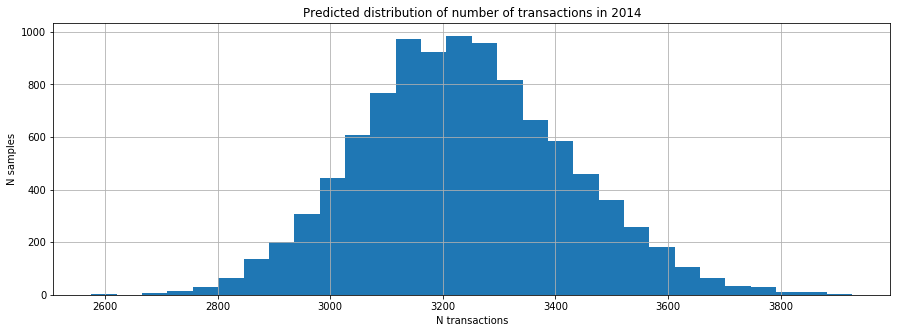

In [11]:
# Time points in 2014 to predict in
x_2014 = np.linspace(365, 365+365, 11)
x_2014 = 0.5*(x_2014[:-1] + x_2014[1:])
print('Time points in 2014 (days from 1st Jan 2013):')
print(x_2014)

# calculate mu values for x_2014 array using model traces
mu_2014 = trace['a'].reshape(-1, 1) * np.exp(- x_2014 / trace['tau'].reshape(-1, 1))
print('\nmu_2014 initial shape:', mu_2014.shape)

# reduce to 10,000 traces
mu_2014 = mu_2014[::4]
print('\nm_2014 new shape:', mu_2014.shape)

# sample number of transactions
trans_2014 = stats.poisson.rvs(mu_2014, loc=0, size=mu_2014.shape)
trans_2014 = trans_2014.sum(axis=1)  # sum over entire 2014 year

figsize(15, 5)
_ = plt.hist(trans_2014, bins=30)
plt.title('Predicted distribution of number of transactions in 2014')
plt.xlabel('N transactions')
plt.ylabel('N samples')
plt.grid()

### Predict total customer spending in 2014

Max probability total spent value: 771310.0
95% confidence interval: [696610. 850742.]


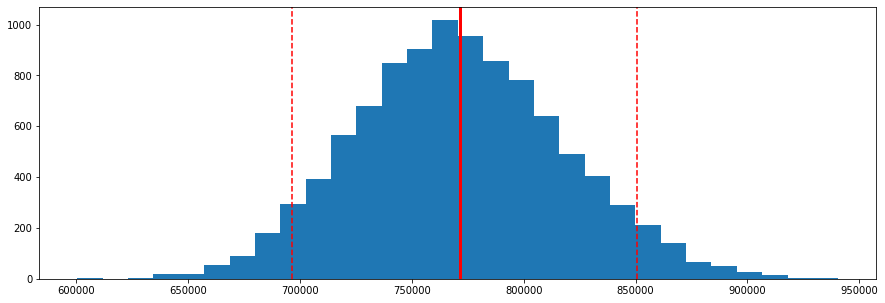

In [12]:
total_spent = [stats.lognorm.rvs(shape, loc, scale, size=x).sum() for x in trans_2014]

max_prob = np.around(np.mean(total_spent))
conf_interval = np.around(np.quantile(total_spent, [0.05, 0.95]))

print('Max probability total spent value:', max_prob)
print('95% confidence interval:', conf_interval)

_ = plt.hist(total_spent, bins=30)
_ = plt.axvline(max_prob, color='r', ls='-', lw=3)
_ = plt.axvline(conf_interval[0], color='r', ls='--')
_ = plt.axvline(conf_interval[1], color='r', ls='--')

## Appendix
### Churn analysis

In [13]:
# Some users are duplicated

print('Initial number of UserIDs in the users file:', users.shape[0])
print('Number of duplicated UserIDs:', users[users.UserID.duplicated()].shape[0])

# remove duplicates
users = users[~users.UserID.duplicated()]

print('\nFinal number of UserIDs:', users.shape[0])

Initial number of UserIDs in the users file: 5021
Number of duplicated UserIDs: 21

Final number of UserIDs: 5000


In [14]:
# Suppose that a customer has left if he/she didn't make any purchase in 2013

date_2013 = arrow.get('2013-01-01').datetime.replace(tzinfo=None)

churn = (trans
         .groupby('UserID', as_index=False)
         .agg({'OrderDate_GMT':'max'})
         .assign(churn = lambda x: [1 if y < date_2013 else 0 for y in x.OrderDate_GMT])
         .loc[:, ['UserID', 'churn']]
         .merge(users, on='UserID')
        )

print('Churn distribution:')
print(churn.churn.value_counts())

churn.head(5)

Churn distribution:
1    3835
0    1165
Name: churn, dtype: int64


,UserID,churn,Birthday,IsSubscribed,SubscribeDate,GenderFinal,IsVIP,HasUsedWishlist,IsUsingMultipleDevices,SK_GeoCountry
0,6482,1,NaN,Yes,2009-02-02 17:55:18.520,Women,Not VIP,No,No,13
1,10834,1,NaN,Yes,2009-02-23 15:41:59.090,Women,Not VIP,Yes,No,70
2,11002,0,NaN,Yes,2009-02-27 16:11:06.810,Women,Not VIP,No,No,216
3,13634,1,NaN,Yes,2009-03-16 11:31:13.170,Women,Not VIP,No,No,37
4,15534,1,NaN,Yes,2009-03-30 11:23:40.160,N/D,Not VIP,Yes,No,101


In [15]:
# Some data formatting

churn = (churn
          # use log10(UserID)
          .assign(UserID = lambda x: x.UserID.apply(lambda y: np.log10(y)),
                  # Birthday == 1 if provided else 0
                  Birthday = lambda x: [1 if type(y)==str else 0 for y in x.Birthday],
                  # year of subscription else -1
                  SubscribeDate = lambda x: [arrow.get(z).year - 2000 if y=='Yes' else -1 for y, z in zip(x.IsSubscribed, x.SubscribeDate)],
                  # 1 if subscribed else 0
                  IsSubscribed = lambda x: [1 if y=='Yes' else 0 for y in x.IsSubscribed],
                  # 1 if any VIP else 0
                  IsVIP = lambda x: [0 if y=='Not VIP' else 1 for y in x.IsVIP],
                  # 1 if has used a wishlist else 0
                  HasUsedWishlist = lambda x: [1 if y=='Yes' else 0 for y in x.HasUsedWishlist],
                  # 1 if used multiple devices
                  IsUsingMultipleDevices = lambda x: [1 if y=='Yes' else 0 for y in x.IsUsingMultipleDevices])
         )
churn.head(5)

,UserID,churn,Birthday,IsSubscribed,SubscribeDate,GenderFinal,IsVIP,HasUsedWishlist,IsUsingMultipleDevices,SK_GeoCountry
0,3.811709,1,0,1,9,Women,0,0,0,13
1,4.034789,1,0,1,9,Women,0,1,0,70
2,4.041472,0,0,1,9,Women,0,0,0,216
3,4.134623,1,0,1,9,Women,0,0,0,37
4,4.191283,1,0,1,9,N/D,0,1,0,101


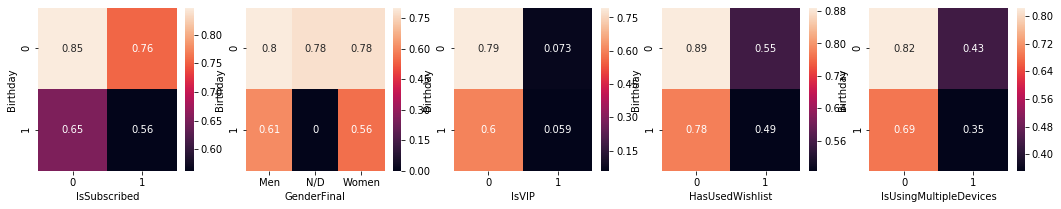

In [16]:
def plot_heatmap(column1, column2, ax=None):
    sns.heatmap(pd.pivot_table(churn,
                               index=column1,
                               columns=column2,
                               values='churn',
                               aggfunc=np.mean,
                               fill_value=0),
                annot=True, ax=ax)

figsize(18, 3)

plot_heatmap('Birthday', 'IsSubscribed', ax=plt.subplot(151))
plot_heatmap('Birthday', 'GenderFinal', ax=plt.subplot(152))
plot_heatmap('Birthday', 'IsVIP', ax=plt.subplot(153))
plot_heatmap('Birthday', 'HasUsedWishlist', ax=plt.subplot(154))
plot_heatmap('Birthday', 'IsUsingMultipleDevices', ax=plt.subplot(155))

In [17]:
# Year of subscription

(pd.crosstab(churn.churn, churn.SubscribeDate)
 .T
 .assign(churn_ratio=lambda x: x[1] / (x[0] + x[1]))
 .sort_values('churn_ratio', ascending=False)
)

churn,0,1,churn_ratio
SubscribeDate,,,
-1,261,1324,0.835331
12,605,2060,0.772983
9,15,36,0.705882
10,42,100,0.704225
11,113,186,0.622074
15,29,40,0.579710
14,45,61,0.575472
13,53,27,0.337500
8,2,1,0.333333


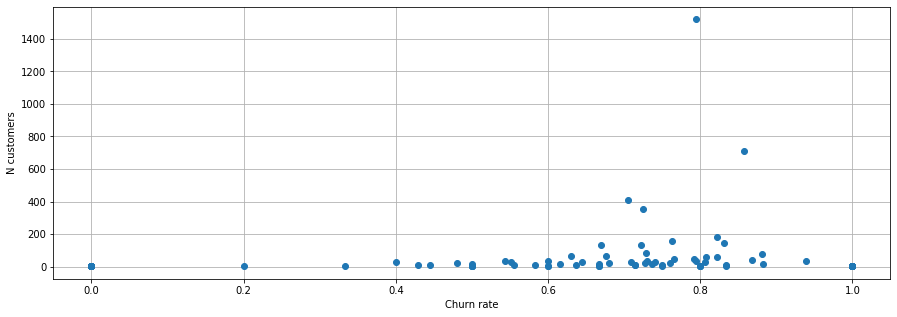

In [20]:
# Distribution of churn for SK_GeoCountry feature

figsize(15, 5)

geo = churn.groupby('SK_GeoCountry').agg({'churn':[np.mean, 'count']})
geo.columns = ['churn', 'n']

plt.plot(geo.churn, geo.n, 'o')
plt.xlabel('Churn rate')
plt.ylabel('N customers')
plt.grid()

In [21]:
# Example when customers subscribed in 2014 but didn't make any purchase in 2013

churn[(churn.SubscribeDate==14) & (churn.churn==1)]

,UserID,churn,Birthday,IsSubscribed,SubscribeDate,GenderFinal,IsVIP,HasUsedWishlist,IsUsingMultipleDevices,SK_GeoCountry
1548,6.252115,1,1,1,14,Women,0,1,1,70
2322,6.365001,1,0,1,14,Men,0,0,0,216
2857,6.435864,1,0,1,14,N/D,0,1,0,169
2875,6.438393,1,0,1,14,Women,0,1,0,13
2884,6.439116,1,0,1,14,Men,1,1,0,216
...,...,...,...,...,...,...,...,...,...,...
4834,6.668849,1,0,1,14,N/D,0,1,0,216
4841,6.669580,1,0,1,14,N/D,0,0,0,793456
4874,6.673101,1,0,1,14,Men,0,0,0,215
4910,6.677860,1,0,1,14,Women,0,0,0,216


### Model churn

In [22]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV


gscv = GridSearchCV(CatBoostClassifier(),
                    param_grid={'iterations':range(5, 15),
                                'learning_rate':[0.02, 0.03, 0.04, 0.05, 0.06],
                                'max_depth':[5, 6, 7, 8, 9, 10]},
                    scoring='f1',
                    cv=5,
                    n_jobs=-1,
                    verbose=0)

gscv.fit(churn.loc[:, churn.columns[~churn.columns.isin(['churn'])]], churn.churn.values, cat_features=range(1, 9))

print('Best params:', gscv.best_params_)
print('Best F1 score:', gscv.best_score_)

0:	learn: 0.6730280	total: 50.9ms	remaining: 560ms
1:	learn: 0.6544880	total: 55.7ms	remaining: 279ms
2:	learn: 0.6381298	total: 60.7ms	remaining: 182ms
3:	learn: 0.6239526	total: 64ms	remaining: 128ms
4:	learn: 0.6097648	total: 68.2ms	remaining: 95.5ms
5:	learn: 0.5968346	total: 73.3ms	remaining: 73.3ms
6:	learn: 0.5849995	total: 76.2ms	remaining: 54.4ms
7:	learn: 0.5744279	total: 79.7ms	remaining: 39.8ms
8:	learn: 0.5647678	total: 83.3ms	remaining: 27.8ms
9:	learn: 0.5558812	total: 85.4ms	remaining: 17.1ms
10:	learn: 0.5472693	total: 89.7ms	remaining: 8.15ms
11:	learn: 0.5402852	total: 92.1ms	remaining: 0us
Best params: {'iterations': 12, 'learning_rate': 0.05, 'max_depth': 9}
Best F1 score: 0.8793394926263132


### Feature importance

In [23]:
gscv.best_estimator_.get_feature_importance(prettified=True)

,Feature Id,Importances
0,HasUsedWishlist,73.841700
1,IsUsingMultipleDevices,21.440017
2,IsVIP,2.896289
3,SubscribeDate,0.577490
4,GenderFinal,0.548380
5,UserID,0.400005
6,Birthday,0.296118
7,IsSubscribed,0.000000
8,SK_GeoCountry,0.000000
